In [0]:
#Downloading the Datasets
!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/train_file/train_fuSp8nd.csv"\
      -O "/tmp/train.csv"

!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/test_file/test_B0QdNpj.csv"\
      -O "/tmp/test.csv"

--2020-04-25 18:10:55--  https://datahack-prod.s3.amazonaws.com/train_file/train_fuSp8nd.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.96
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94844 (93K) [text/csv]
Saving to: ‘/tmp/train.csv’

/tmp/train.csv      100%[===================>]  92.62K   133KB/s    in 0.7s    

2020-04-25 18:10:57 (133 KB/s) - ‘/tmp/train.csv’ saved [94844/94844]

--2020-04-25 18:10:59--  https://datahack-prod.s3.amazonaws.com/test_file/test_B0QdNpj.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.108
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19402 (19K) [text/csv]
Saving to: ‘/tmp/test.csv’

/tmp/test.csv       100%[===================>]  1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#I have downloaded the data to my Google Drive. Unzipping the train and test folders containing the audio
import os
import zipfile

local_zip='/content/drive/My Drive/train2.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/trainlast')
zip_ref.close()


local_zip='/content/drive/My Drive/test1.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/testlast')
zip_ref.close()


In [0]:
#Importing the csv files that contains the labels of the sounds
import pandas as pd
train=pd.read_csv('/tmp/trainlast/train.csv')
test=pd.read_csv('/tmp/testlast/test.csv')

In [0]:
train.tail(5)

,ID,Class
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling
5434,8729,air_conditioner


Class Distribution:
 jackhammer          668
engine_idling       624
siren               607
dog_bark            600
children_playing    600
drilling            600
street_music        600
air_conditioner     600
car_horn            306
gun_shot            230
Name: Class, dtype: int64


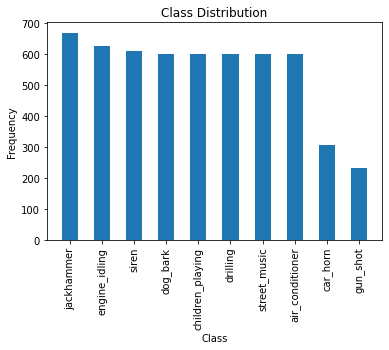

In [0]:
#Class Distribution
train['Class'].value_counts()
import numpy as np
import matplotlib.pyplot as plt
plt.bar(train['Class'].value_counts().index, train['Class'].value_counts(), width=0.5, bottom=None, align='center', data=train)
plt.title('Class Distribution')
plt.xticks(rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Frequency')
print('Class Distribution:\n',train['Class'].value_counts())

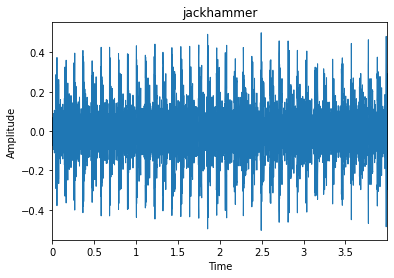

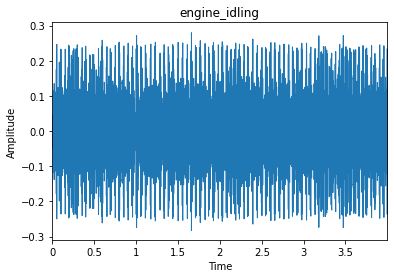

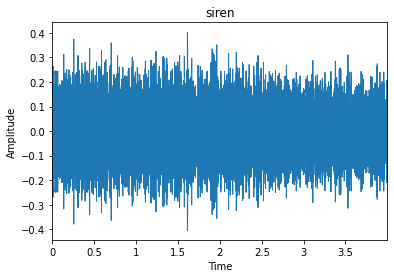

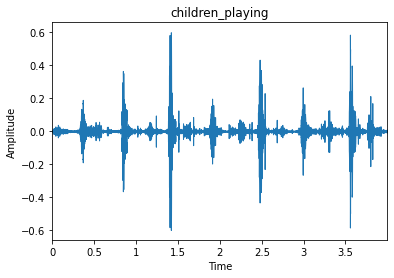

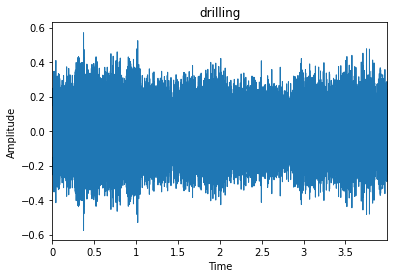

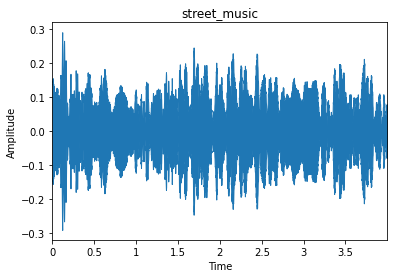

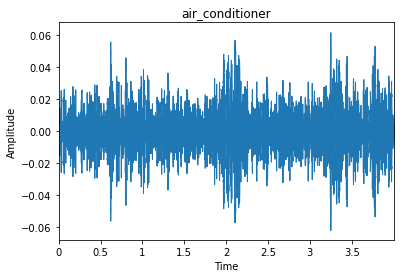

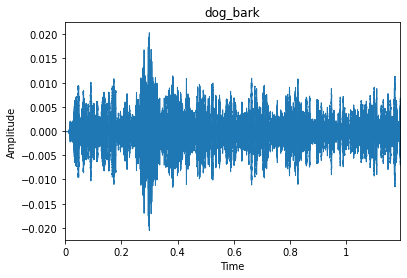

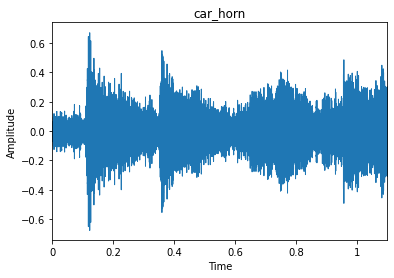

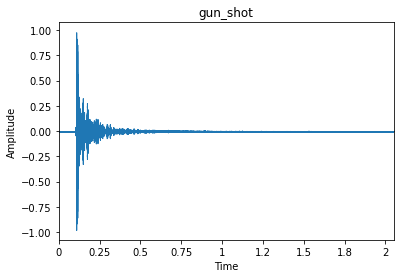

In [0]:
#Let's visualize the sound files of different classes
Classes=['jackhammer','engine_idling','siren','children_playing','drilling','street_music','air_conditioner','dog_bark','car_horn','gun_shot']

import librosa
import librosa.display
import random

def get_index(c): #function to randomize the index of the classes
  return random.choice(train.loc[train.Class==c].index)

for i in range(len(Classes)):
  j=get_index(Classes[i])
  x, sr = librosa.load('/tmp/trainlast/Train/' + str(train.ID[j]) + '.wav')

  plt.figure(figsize=(6, 4))
  librosa.display.waveplot(x, sr=sr)
  plt.ylabel('Amplitude')
  plt.title(train.Class[j])
  plt.pause(0.05)


  
plt.show()

In [0]:
#getting the features and labels of audios in the train set
features=[]
labels=[]
for i in range(len(train)):
  filename='/tmp/trainlast/Train/' + str(train.ID[i]) + '.wav'
  x, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
  features.append(np.mean(librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=40).T,axis=0))
  labels.append(train.Class[i])


In [0]:
#getting the features of audios in the test set
features_test=[]
labels1=[]
for i in range(len(test)):
  filename='/tmp/testlast/Test/' + str(test.ID[i]) + '.wav'
  x, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
  features_test.append(np.mean(librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=40).T,axis=0))

In [0]:
#converting the audio features to numpy array
x=np.array(features)
x_test=np.array(features_test)

#encoding the labels
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y = to_categorical(le.fit_transform(labels)) 

Using TensorFlow backend.


In [0]:
#Dimension of Data
print('Shape of Features(Train): ',x.shape)
print('Shape of Features(Test): ',x_test.shape)
print('Shape of Labels(Train): ',y.shape)

Shape of Features(Train):  (5435, 40)
Shape of Features(Test):  (3297, 40)
Shape of Labels(Train):  (5435, 10)


## **ANN

In [0]:
#ANN ALGORITHM
from keras import Sequential
from keras.layers import Dense,Dropout,Activation
model=Sequential()
model.add(Dense(units=256,activation='relu',input_dim=40))
model.add(Dropout(0.5))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x,y, epochs=100,validation_data=(x,y),batch_size=32)


Train on 5435 samples, validate on 5435 samples
Epoch 1/100
5435/5435 [==============================] - 3s 516us/step - loss: 9.3846 - accuracy: 0.1492 - val_loss: 2.1882 - val_accuracy: 0.1904
Epoch 2/100
5435/5435 [==============================] - 1s 168us/step - loss: 2.6216 - accuracy: 0.1796 - val_loss: 2.1880 - val_accuracy: 0.1834
Epoch 3/100
5435/5435 [==============================] - 1s 165us/step - loss: 2.2878 - accuracy: 0.1923 - val_loss: 2.1110 - val_accuracy: 0.2351
Epoch 4/100
5435/5435 [==============================] - 1s 168us/step - loss: 2.1949 - accuracy: 0.2123 - val_loss: 2.0602 - val_accuracy: 0.2815
Epoch 5/100
5435/5435 [==============================] - 1s 168us/step - loss: 2.0682 - accuracy: 0.2664 - val_loss: 1.9492 - val_accuracy: 0.3494
Epoch 6/100
5435/5435 [==============================] - 1s 165us/step - loss: 2.0001 - accuracy: 0.2916 - val_loss: 1.8308 - val_accuracy: 0.4040
Epoch 7/100
5435/5435 [==============================] - 1s 166us/step

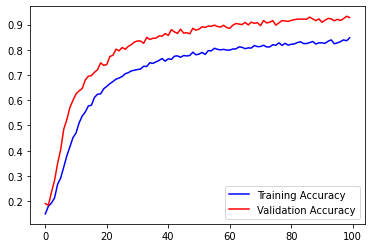

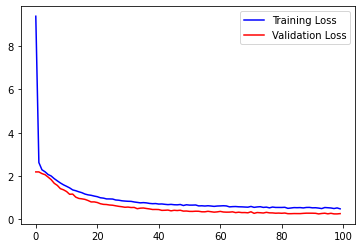

In [0]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()
print()

In [0]:
print(acc)

[0.14921804, 0.17957681, 0.1922723, 0.21232751, 0.26642135, 0.29162833, 0.3348666, 0.37939283, 0.4149034, 0.45170194, 0.4701012, 0.5103956, 0.5370745, 0.55308187, 0.5771849, 0.5803128, 0.6112236, 0.62391907, 0.625023, 0.6454462, 0.6550138, 0.66550136, 0.67414904, 0.68353266, 0.68813246, 0.6940202, 0.7050598, 0.70929164, 0.7162833, 0.71904325, 0.7218031, 0.72382706, 0.7348666, 0.7337626, 0.74866605, 0.7460902, 0.7519779, 0.75786567, 0.7652254, 0.7549218, 0.7643054, 0.76172954, 0.774425, 0.77589697, 0.77037716, 0.7773689, 0.77552897, 0.7773689, 0.7904324, 0.7801288, 0.7828887, 0.7895124, 0.7816007, 0.79668814, 0.79595214, 0.80607176, 0.80183995, 0.799632, 0.80165595, 0.798896, 0.7987121, 0.8031279, 0.8034959, 0.81140757, 0.8099356, 0.8044158, 0.8075437, 0.80680776, 0.8169273, 0.8125115, 0.8128795, 0.81803125, 0.81122357, 0.81140757, 0.8202392, 0.8178473, 0.82741493, 0.8174793, 0.825575, 0.81858325, 0.8218951, 0.82336706, 0.82870287, 0.83183074, 0.824655, 0.824839, 0.82851887, 0.8329347, 

### **The model achieves a validation accuracy of over 90% and from the graph above, we can see that there is no overfitting.**

In [0]:
#Determining the classes of the audios in the test set. We do not have the labels for the test set. I will generate a submission file that would contain the ID
#and classes of the samples in the test set. The accuracy of the test set can be known by submitting to the analytics vidya challenge. 
pred=model.predict(x_test)
b=np.argmax(pred,axis=1)
pred_test=le.inverse_transform(b)

In [0]:
[test_loss, test_acc] = model.evaluate(x,y)
print("Loss = {}, accuracy = {}".format(test_loss, test_acc))

5435/5435 [==============================] - 0s 54us/step
Loss = 0.26009987933216777, accuracy = 0.9280588626861572


In [0]:
#Generating the Class of the audios for the Test set and saving in a .csv file
out_df = pd.DataFrame({'ID':test['ID'].values})
out_df .insert(loc=0, column='Class', value=pred_test)
out_df.to_csv('submission.csv', index=False)

In [0]:
#Viewing the test file
s=pd.read_csv('submission.csv')
s.head(5)

,Class,ID
0,drilling,5
1,children_playing,7
2,drilling,8
3,children_playing,9
4,engine_idling,13


## **Convolutional Neural Network (CNN)**

In [0]:
#Here, I am extracting the mfccs for 10 audio samples
mfccs=[]
for i in range(len(train[:10])):
  file_name='/tmp/trainlast/Train/' + str(train.ID[i+100]) + '.wav'
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
  mfccs.append(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40))

In [0]:
#Each of the samples has 40 rows but variable number of columns
for i in range(len(mfccs)):
  print(len(mfccs[i][0]))

173
99
173
173
173
95
173
173
173
127


In [0]:
#CNN doesnot support variable column length. We will have to fix the column length and pad them
max_pad_len=174 # I am defining a maximum length for each column 

file_name='/tmp/trainlast/Train/12.wav'
audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
mfcc=librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
print('Shape of feature matrix: ',mfcc.shape)
pad_width = max_pad_len - mfcc.shape[1]
print('Pad width: up',pad_width)
mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
print('Shape of feature matrix after padding: ',mfcc.shape)

Shape of feature matrix:  (40, 50)
Pad width: up 124
Shape of feature matrix after padding:  (40, 174)


In [0]:
#Let's do the stuff mentioned above for all the training samples
features_new=[]
labels=[]
max_pad_len=174 

for i in range(len(train)):
  filename='/tmp/trainlast/Train/' + str(train.ID[i]) + '.wav'
  x, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
  mfcc=librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40)
  pad_width = max_pad_len - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  features_new.append(mfcc)
  labels.append(train.Class[i])

In [0]:
#Let's do the stuff mentioned above for all the test samples
features_new_test=[]
max_pad_len=174 

for i in range(len(test)):
  filename='/tmp/testlast/Test/' + str(test.ID[i]) + '.wav'
  x, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
  mfcc=librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40)
  pad_width = max_pad_len - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  features_new_test.append(mfcc)

In [0]:
x_new=np.array(features_new)  #coverting the features vector to a numpy array
x_new=x_new.reshape(x_new.shape[0], 40, 174, 1) #reshaping the array for the convolution layer input

x_new_test=np.array(features_new_test)  
x_new_test=x_new_test.reshape(x_new_test.shape[0], 40, 174, 1)

#encoding the labels
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))

In [0]:
#Dimension of Data
print('Shape of Features(Train): ',x_new.shape)
print('Shape of Features(Test): ',x_new_test.shape)
print('Shape of Labels(Train): ',y.shape)

Shape of Features(Train):  (5435, 40, 174, 1)
Shape of Features(Test):  (3297, 40, 174, 1)
Shape of Labels(Train):  (5435, 10)


In [0]:
#import tensorflow as tf
#from keras import regularizers

#model3=tf.keras.models.Sequential([
    
    #tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(40,174,1)),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
   # tf.keras.layers.MaxPooling2D(2,2),
   # tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
   # tf.keras.layers.MaxPooling2D(2#,2),
    #tf.keras.layers.Dropout(0.4),
    
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256,activation='relu'),
    #tf.keras.layers.Dropout(0.5),
   # tf.keras.layers.Dense(256,activation='relu'),
   # tf.keras.layers.Dropout(0.5),
    
  #  tf.keras.layers.Dense(10,activation='softmax')
#])
    
#model2=tf.keras.models.Sequential([
    
    #tf.keras.layers.Conv2D(16,(3,3),dilation_rate=(2, 2),activation='relu',input_shape=(40,174,1)),
    #tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(32,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(64,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(128,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.4),
    
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256,activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256,activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    
    #tf.keras.layers.Dense(10,activation='softmax')
#])

In [0]:
#DILATED CNN WITH DILATION 2
import tensorflow as tf
from keras import regularizers
model21=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),dilation_rate=(2, 2),activation='relu',input_shape=(40,174,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256,(3,3),dilation_rate=(2, 2),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax')
])

In [0]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model21.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history1=model21.fit(x_new,y, batch_size=32, epochs=100, validation_split=0.1,callbacks=[reduce])

Epoch 1/100
153/153 [==============================] - 2s 10ms/step - loss: 0.1168 - accuracy: 0.9757 - val_loss: 0.3349 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 2/100
153/153 [==============================] - 1s 9ms/step - loss: 0.0536 - accuracy: 0.9886 - val_loss: 0.6087 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 3/100
153/153 [==============================] - 1s 9ms/step - loss: 0.0946 - accuracy: 0.9755 - val_loss: 0.9455 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 4/100
153/153 [==============================] - 1s 9ms/step - loss: 0.1293 - accuracy: 0.9720 - val_loss: 0.4001 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 5/100
153/153 [==============================] - 1s 9ms/step - loss: 0.1110 - accuracy: 0.9714 - val_loss: 0.4205 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/100
153/153 [==============================] - 1s 9ms/step - loss: 0.0809 - accuracy: 0.9787 - val_loss: 0.2783 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 7/100
153/153 [==============================] - 1s 9ms/s

In [0]:
pred1=model21.predict(x_new_test)
b=np.argmax(pred1,axis=1)
pred_test1=le.inverse_transform(b)

In [0]:
#Generating the Class of the audios for the Test set and saving in a .csv file
out_df = pd.DataFrame({'ID':test['ID'].values})
out_df .insert(loc=0, column='Class', value=pred_test1)
out_df.to_csv('submission1.csv', index=False)

In [0]:
#Viewing the test file
s=pd.read_csv('submission1.csv')
s.head(5)

,Class,ID
0,drilling,5
1,children_playing,7
2,drilling,8
3,dog_bark,9
4,street_music,13


In [0]:
acc1=history1.history['accuracy']
val_acc1=history1.history['val_accuracy']

In [0]:
acc1.shape


AttributeError: ignored

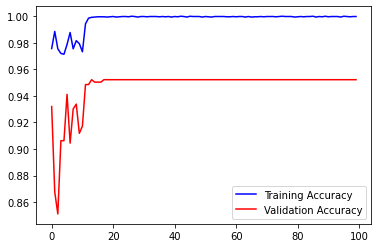

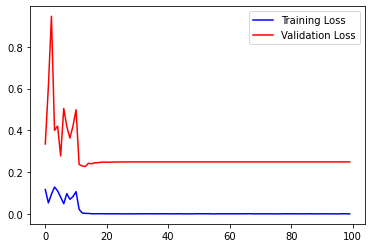

In [0]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc1=history1.history['accuracy']
val_acc1=history1.history['val_accuracy']
loss1=history1.history['loss']
val_loss1=history1.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc1,'b',label='Training Accuracy')
plt.plot(epochs,val_acc1,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss1,'b',label='Training Loss')
plt.plot(epochs,val_loss1,'r',label='Validation Loss')
plt.legend()
plt.show()

In [0]:
model30=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),dilation_rate=(3, 3),activation='relu',input_shape=(40,174,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32,(3,3),dilation_rate=(3, 3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),dilation_rate=(3, 3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3),dilation_rate=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256,(3,3),dilation_rate=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax')
])

In [0]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model30.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history2=model30.fit(x_new,y, batch_size=32, epochs=100, validation_split=0.1,callbacks=[reduce])

Epoch 1/100
153/153 [==============================] - 2s 12ms/step - loss: 1.8695 - accuracy: 0.2985 - val_loss: 1.4716 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 2/100
153/153 [==============================] - 2s 10ms/step - loss: 1.0908 - accuracy: 0.6095 - val_loss: 0.8416 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 3/100
153/153 [==============================] - 2s 10ms/step - loss: 0.7304 - accuracy: 0.7636 - val_loss: 0.6383 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 4/100
153/153 [==============================] - 2s 10ms/step - loss: 0.5373 - accuracy: 0.8229 - val_loss: 0.5406 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 5/100
153/153 [==============================] - 2s 10ms/step - loss: 0.4407 - accuracy: 0.8536 - val_loss: 0.4531 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 6/100
153/153 [==============================] - 2s 10ms/step - loss: 0.3380 - accuracy: 0.8896 - val_loss: 0.5104 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 7/100
153/153 [==============================] - 2s 




































































































































### **Compared to the MLP model, the CNN model achieves higher accuracy in both training and validation sets. Also, no overfitting can be observed in the graphs above.**

In [0]:
#Determining the classes of the audios in the test set. We do not have the labels for the test set. I will generate a submission file that would contain the ID
#and classes of the samples in the test set.
pred2=model30.predict(x_new_test)
b=np.argmax(pred2,axis=1)
pred_test2=le.inverse_transform(b)

In [0]:
#Generating the Class of the audios for the Test set and saving in a .csv file
out_df = pd.DataFrame({'ID':test['ID'].values})
out_df .insert(loc=0, column='Class', value=pred_test2)
out_df.to_csv('submission2.csv', index=False)

In [0]:
#Viewing the test file
s=pd.read_csv('submission2.csv')
s.head(5)

,Class,ID
0,drilling,5
1,children_playing,7
2,drilling,8
3,dog_bark,9
4,street_music,13


In [0]:
[test_loss, test_acc] = model2.evaluate(x_new,y)
print("Loss = {}, accuracy = {}".format(test_loss, test_acc))

170/170 [==============================] - 1s 4ms/step - loss: 0.0784 - accuracy: 0.9798
Loss = 0.07843289524316788, accuracy = 0.9797608256340027


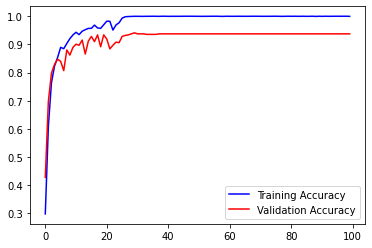

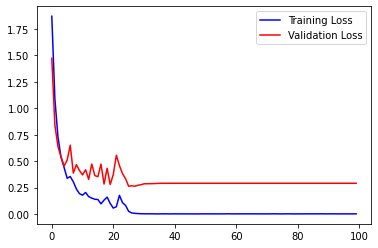

In [0]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc2=history2.history['accuracy']
val_acc2=history2.history['val_accuracy']
loss2=history2.history['loss']
val_loss2=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc2,'b',label='Training Accuracy')
plt.plot(epochs,val_acc2,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss2,'b',label='Training Loss')
plt.plot(epochs,val_loss2,'r',label='Validation Loss')
plt.legend()
plt.show()

In [0]:
[test_loss, test_acc] = model2.evaluate(x_test,y)
print("Loss = {}, accuracy = {}".format(test_loss, test_acc))

ValueError: ignored

In [0]:
#NORMAL CNN

import tensorflow as tf
#from keras import regularizers

model29=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(40,174,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(10,activation='softmax')
])

In [0]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model29.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history3=model29.fit(x_new,y, batch_size=32, epochs=100, validation_split=0.1,callbacks=[reduce])

Epoch 1/100
153/153 [==============================] - 1s 7ms/step - loss: 2.5977 - accuracy: 0.1552 - val_loss: 2.1065 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 2/100
153/153 [==============================] - 1s 6ms/step - loss: 1.9234 - accuracy: 0.2965 - val_loss: 1.7912 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 3/100
153/153 [==============================] - 1s 6ms/step - loss: 1.6728 - accuracy: 0.3872 - val_loss: 1.5270 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 4/100
153/153 [==============================] - 1s 6ms/step - loss: 1.4336 - accuracy: 0.4929 - val_loss: 1.3465 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 5/100
153/153 [==============================] - 1s 6ms/step - loss: 1.2311 - accuracy: 0.5794 - val_loss: 1.0914 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 6/100
153/153 [==============================] - 1s 6ms/step - loss: 1.0391 - accuracy: 0.6424 - val_loss: 0.9717 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 7/100
153/153 [==============================] - 1s 6ms/st

In [0]:
#Determining the classes of the audios in the test set. We do not have the labels for the test set. I will generate a submission file that would contain the ID
#and classes of the samples in the test set.
pred3=model29.predict(x_new_test)
b=np.argmax(pred3,axis=1)
pred_test3=le.inverse_transform(b)

In [0]:
#Generating the Class of the audios for the Test set and saving in a .csv file
out_df = pd.DataFrame({'ID':test['ID'].values})
out_df .insert(loc=0, column='Class', value=pred_test3)
out_df.to_csv('submission3.csv', index=False)

In [0]:
#Viewing the test file
s=pd.read_csv('submission3.csv')
s.head(5)

,Class,ID
0,jackhammer,5
1,children_playing,7
2,drilling,8
3,dog_bark,9
4,street_music,13


In [0]:
[test_loss, test_acc] = model2.evaluate(x_test,y)
print("Loss = {}, accuracy = {}".format(test_loss, test_acc))

ValueError: ignored

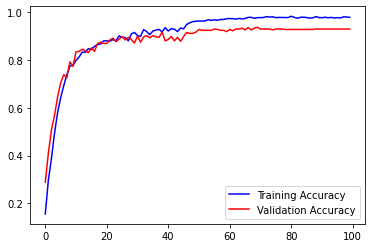

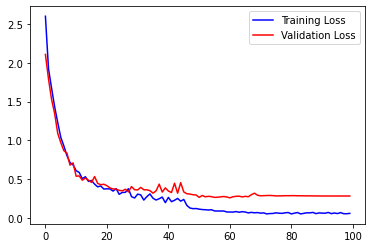

In [0]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc3=history3.history['accuracy']
val_acc3=history3.history['val_accuracy']
loss3=history3.history['loss']
val_loss3=history3.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc3,'b',label='Training Accuracy')
plt.plot(epochs,val_acc3,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss3,'b',label='Training Loss')
plt.plot(epochs,val_loss3,'r',label='Validation Loss')
plt.legend()
plt.show()

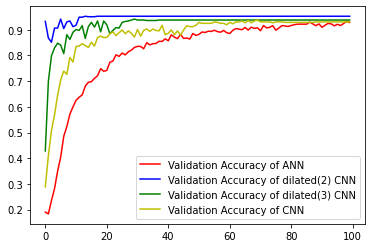

In [0]:
#ACCURACY GRAPH

#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
acc1=history1.history['accuracy']
val_acc1=history1.history['val_accuracy']
acc2=history2.history['accuracy']
val_acc2=history2.history['val_accuracy']
acc3=history3.history['accuracy']
val_acc3=history3.history['val_accuracy']


epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
#plt.plot(epochs,acc3,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy of ANN')

#plt.plot(epochs,acc3,'b',label='Training Accuracy')
plt.plot(epochs,val_acc1,'b',label='Validation Accuracy of dilated(2) CNN')

#plt.plot(epochs,acc3,'b',label='Training Accuracy')
plt.plot(epochs,val_acc2,'g',label='Validation Accuracy of dilated(3) CNN')

#plt.plot(epochs,acc3,'b',label='Training Accuracy')
plt.plot(epochs,val_acc3,'y',label='Validation Accuracy of CNN')


plt.legend()
plt.show()

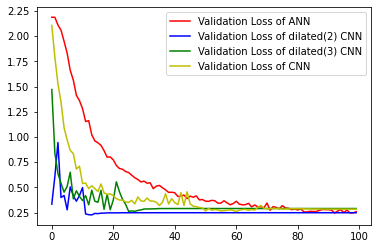

In [0]:
#LOSS GRAPG
#Evaluating Accuracy and Loss of the model
%matplotlib inline
loss=history.history['loss']
val_loss=history.history['val_loss']

loss1=history1.history['loss']
val_loss1=history1.history['val_loss']

loss2=history2.history['loss']
val_loss2=history2.history['val_loss']

loss3=history3.history['loss']
val_loss3=history3.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt



#Plot training and validation loss per epoch
#plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss of ANN')

#plt.plot(epochs,loss1,'b',label='Training Loss')
plt.plot(epochs,val_loss1,'b',label='Validation Loss of dilated(2) CNN')

#plt.plot(epochs,loss2,'b',label='Training Loss')
plt.plot(epochs,val_loss2,'g',label='Validation Loss of dilated(3) CNN')

#plt.plot(epochs,loss3,'b',label='Training Loss')
plt.plot(epochs,val_loss3,'y',label='Validation Loss of CNN')
plt.legend()
plt.show()
